In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt


from encoder_model import EncoderModelV0,EncoderModelV1
from decoder_model import DecoderModelV0
from auto_encoder_model import AutoEncoderModelV0,VariationalAutoEncoderModelV0
from load_data import train_dataloader
from settings import (ZDIM,LEARNING_RATE,EPOCHS,MODEL_PATH,MODEL_SAVE_PATH)

In [2]:
SAVING = True

In [3]:
encoder_model = EncoderModelV1(ZDIM)
decoder_model = DecoderModelV0(ZDIM)

auto_encoder_model = VariationalAutoEncoderModelV0(encoder_model,decoder_model)

In [4]:
optimizer = torch.optim.Adam(auto_encoder_model.parameters(),lr=LEARNING_RATE)
mse_loss_fn = nn.MSELoss()

In [5]:
def reconstruction_loss(data, reconstruction, beta=1.0):
    # Calculate binary cross entropy loss
    bce_loss = F.binary_cross_entropy(reconstruction, data, reduction='none')
    # Sum along the channel dimension and take the mean over batch
    bce_loss = torch.mean(torch.sum(bce_loss, dim=(1, 2, 3)))
    # Multiply by beta
    bce_loss *= beta
    return bce_loss

def kl_loss(z_mean, z_log_var):
    # Calculate KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp(), dim=1)
    # Take the mean over batch
    kl_loss = torch.mean(kl_loss)
    return kl_loss

def total_loss(data, reconstruction, z_mean, z_log_var, beta=1.0):
    recon_loss = reconstruction_loss(data, reconstruction, beta=beta)
    kl_loss_val = kl_loss(z_mean, z_log_var)
    total_loss_val = recon_loss + kl_loss_val
    return total_loss_val

In [6]:
# Train Loop
train_loss_history = []
test_loss_history = []

BETA = 100

for epoch in tqdm(range(EPOCHS)):
    for inputs, labels in train_dataloader:
        z_mean, z_log_var, reconstruction = auto_encoder_model(inputs)
        optimizer.zero_grad()
    
        
        loss = total_loss(inputs,reconstruction,z_mean,z_log_var,beta=BETA)
        
        train_loss_history.append(loss.item())
        loss.backward()
        optimizer.step()
    

        

100%|██████████| 5/5 [09:56<00:00, 119.20s/it]


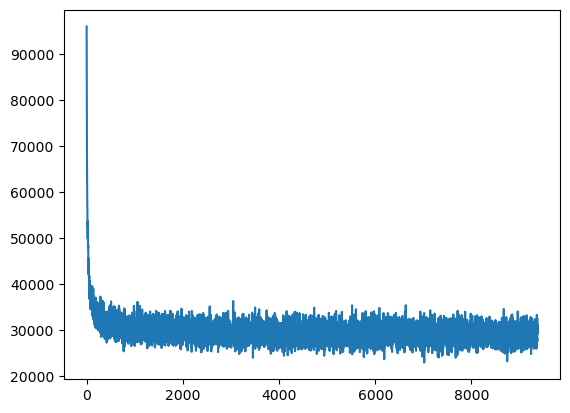

In [7]:
plt.plot(train_loss_history)

In [8]:
if SAVING:
    MODEL_PATH.mkdir(parents=True, exist_ok=True)

    # 3. Save the model state dict 
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=auto_encoder_model.state_dict(), # only saving the state_dict() only saves the models learned parameters
               f=MODEL_SAVE_PATH)

Saving model to: models/ae.pth
